In [203]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq

In [204]:
# differential equations
def fs(s,i):
    return -b*s*i

def fi(s,i):
    return b*s*i-g*i

def fr(s,i):
    return 1-s-i

# set parameters
b=3
g=1

def rungekutta(s0,i0,r0):
    
    # SIR data storage
    S=[]
    I=[]
    R=[]
    
    #initial conditions
    S.append(s0)
    I.append(i0)
    R.append(r0)

    # set simulation time and time step
    t0=0
    t_final=20
    steps=10_001
    time=np.linspace(t0,t_final,steps)
    N=len(time)
    h=time[1]-time[0]

    # runge-kutta coeff
    for i in range(0,N-1):

        k1=fs(S[i],I[i])
        l1=fi(S[i],I[i])

        k2=fs(S[i]+h/2*k1,I[i]+h/2*l1)
        l2=fi(S[i]+h/2*k1,I[i]+h/2*l1)

        k3=fs(S[i]+h/2*k2,I[i]+h/2*l2)
        l3=fi(S[i]+h/2*k2,I[i]+h/2*l2)

        k4=fs(S[i]+h*k3,I[i]+h*k3)
        l4=fi(S[i]+h*k3,I[i]+h*k3)

        # updated values
        S.append(S[i]+h/6*(k1+2*k2+2*k3+k4))
        I.append(I[i]+h/6*(l1+2*l2+2*l3+l4))
        R.append(fr(S[-1],I[-1]))

    return S,I,R,time

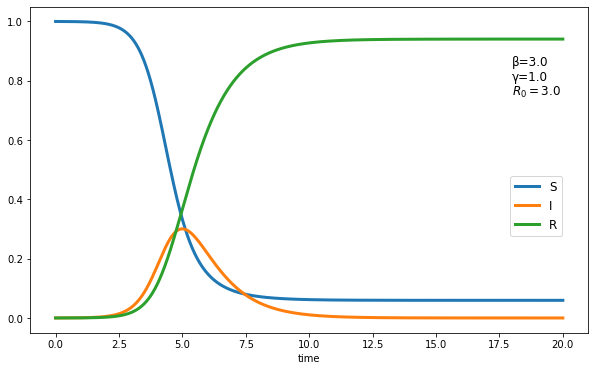

In [205]:
s,i,r,t = rungekutta(s0=1-1e-4,i0=1e-4,r0=0)
fig, ax=plt.subplots(figsize=(10,6))
ax.plot(t,s,t,i,t,r,linewidth=3)
ax.set_xlabel('time')
ax.set_ylabel('')
ax.legend(['S','I','R'],loc='upper left', bbox_to_anchor=(0.85, 0.5),fontsize='large')
ax.text(18,0.85,f'β={float(b)}',fontsize=12)
ax.text(18,0.8,f'γ={float(g)}',fontsize=12)
ax.text(18,0.75,f'$R_0={b/g}$',fontsize=12)
plt.show()


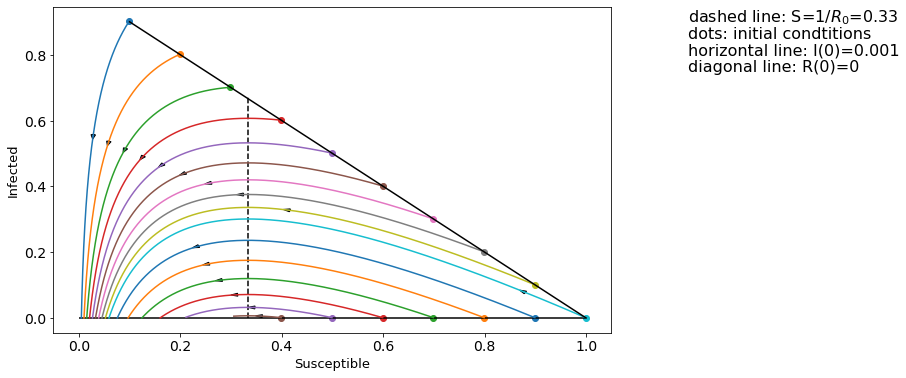

In [206]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

fig, ax2=plt.subplots(figsize=(10,6))
S0=[x/10 for x in range(1,11)]
I0=0.001
for S in S0:
    s,i,_,_=rungekutta(S-I0,1-S+I0,0)
    ax2.plot(s,i)
    ax2.scatter(S-I0,1-S+I0,marker='o')
    p=find_nearest(s,4*np.mean(s))
    dx=s[p]-s[p-1]
    dy=i[p]-i[p-1]
    ax2.arrow(s[p],i[p],dx,dy,width=0.003)
    
R0=[R/10 for R in range(1,7)]
for R in R0:
    s,i,_,_=rungekutta(1-I0-R,I0,r0=R)
    ax2.plot(s,i)
    ax2.scatter(1-I0-R,I0,marker='o')
    p=find_nearest(s,np.mean(s))
    dx=s[p]-s[p-1]
    dy=i[p]-i[p-1]
    ax2.arrow(s[p],i[p],dx,dy,width=0.003)

ax2.vlines(g/b,0,0.67,colors='k',linestyles='dashed')
ax2.hlines(0,0,1,colors='k')
ax2.plot([1,0.1],[0,0.9],'k')
ax2.set_xlabel('Susceptible',fontsize=13)
ax2.set_ylabel('Infected',fontsize=13)
ax2.text(1.2,0.90,f'dashed line: S=$1/R_0$={round(float(g/b),2)}',fontsize=16)
ax2.text(1.2,0.85,f'dots: initial condtitions',fontsize=16)
ax2.text(1.2,0.80,f'horizontal line: I(0)=0.001',fontsize=16)
ax2.text(1.2,0.75,f'diagonal line: R(0)=0',fontsize=16)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
plt.show()

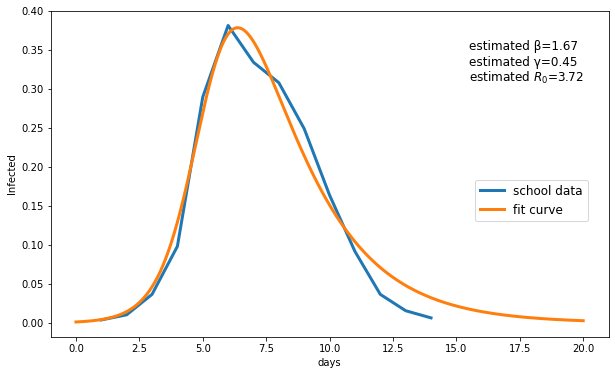

In [207]:
# data fitting

pop=763
days=[float(x) for x in range(1,15)]
infected=[3,8,28,75,221,291,255,235,190,125,70,28,12,5]
infected=[x/pop for x in infected]

# initial conditions for t=0 and i(0)=1 person infected
pop=763
s0=(pop-1)/pop
i0=1/pop
r0=0

def i_fit(default_x,b,g):

    # initialize 
    S=[]
    I=[]
    R=[]
    Ifit=[]
    S.append(s0)
    I.append(i0)
    R.append(r0)

    # set simulation time and time step
    t0=0
    t_final=20
    steps=10_001
    time=np.linspace(t0,t_final,steps)
    N=len(time)
    h=time[1]-time[0]
    # calculale for t>0
    t=t0
    t=t+h

    # runge-kutta coeff
    for i in range(0,N-1):

        k1=-b*S[i]*I[i]
        l1=b*S[i]*I[i] -g*I[i]

        k2=-b*(S[i]+h/2*k1)*(I[i]+h/2*l1)
        l2=b*(S[i]+h/2*k1)*(I[i]+h/2*l1) -g*(I[i]+h/2*l1)

        k3=-b*(S[i]+h/2*k2)*(I[i]+h/2*l2)
        l3=b*(S[i]+h/2*k2)*(I[i]+h/2*l2) -g*(I[i]+h/2*l2)

        k4=-b*(S[i]+h*k3)*(I[i]+h*k3)
        l4=b*(S[i]+h*k3)*(I[i]+h*k3) -g*(I[i]+h*k3)

        # update values
        S.append(S[i]+h/6*(k1+2*k2+2*k3+k4))
        I.append(I[i]+h/6*(l1+2*l2+2*l3+l4))

        if round(t,4) in days:
            Ifit.append(I[i]+h/6*(l1+2*l2+2*l3+l4))

        # update time
        t=t+h

    return Ifit

popt,pcov=curve_fit(i_fit,days,infected,bounds=(0,[2,2]))
#print (popt,pcov)
fig ,ax3=plt.subplots(figsize=(10,6))
ifit=i_fit(None,popt[0],popt[1])
b,g=popt[0],popt[1]
_,ifit,_,t=rungekutta(s0,i0,r0)
ax3.plot(days,infected,t,ifit,linewidth=3)
ax3.text(15.5,0.35,f'estimated β={round(b,2)}',fontsize=12)
ax3.text(15.5,0.33,f'estimated γ={round(g,2)}',fontsize=12)
ax3.text(15.5,0.31,f'estimated $R_0$={round(b/g,2)}',fontsize=12)
ax3.legend(['school data','fit curve'],loc='upper left', bbox_to_anchor=(0.75, 0.5),fontsize='large')
ax3.set_xlabel('days')
ax3.set_ylabel('Infected')
plt.show()

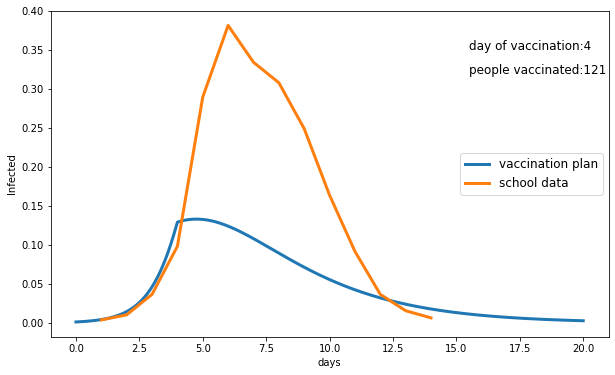

In [208]:
# vaccination plan 
# differential equations
def fs(s,i):
    return -b*s*i

def fi(s,i):
    return b*s*i-g*i

def fr(s,i):
    return 1-s-i

# set parameters
b=1.6662 
g=0.4478

pop=763
days=[float(x) for x in range(1,15)]
infected=[3,8,28,75,221,291,255,235,190,125,70,28,12,5]
infected=[x/pop for x in infected]

def vac(k,vday):
    
    # SIR data storage
    S=[]
    I=[]
    R=[]
    pop=763
    s0=(pop-1)/pop
    i0=1/pop
    r0=0
    
    #initial conditions
    S.append(s0)
    I.append(i0)
    R.append(r0)

    # set simulation time and time step
    t0=0
    t_final=20
    steps=10_001
    time=np.linspace(t0,t_final,steps)
    N=len(time)
    h=time[1]-time[0]
    t=h
    # runge-kutta coeff
    for i in range(0,N-1):

        k1=fs(S[i],I[i])
        l1=fi(S[i],I[i])

        k2=fs(S[i]+h/2*k1,I[i]+h/2*l1)
        l2=fi(S[i]+h/2*k1,I[i]+h/2*l1)

        k3=fs(S[i]+h/2*k2,I[i]+h/2*l2)
        l3=fi(S[i]+h/2*k2,I[i]+h/2*l2)

        k4=fs(S[i]+h*k3,I[i]+h*k3)
        l4=fi(S[i]+h*k3,I[i]+h*k3)

        # updated values
        
        I.append(I[i]+h/6*(l1+2*l2+2*l3+l4))


        if round(t,4)==vday:
            S.append(S[-1]-k)
            R.append(R[-1]+k)
        else:
            S.append(S[i]+h/6*(k1+2*k2+2*k3+k4))
            R.append(fr(S[-1],I[-1]))
        t=t+h

    return S,I,R,time


temp=pop
temps=[]
tempi=[]
tempr=[]
#search for minumun people to be vaccinated with a set maxinum of infected
for vday in range(2,8):# search for vaccination day from 2nd to 8th
    for k in range(1,6):# search for fraction to be vaccinated
        s,i,r,tt=vac(k/10,vday) 
        if max(i)<0.20 and min(s)>0: #set maximun infected at pick and check if s>0 because we subtract random k mumber
            for inx,T in enumerate(tt):
                if round(T,4)==vday:
                    if s[inx]*k/10*pop<temp:
                        temp=s[inx]*k/10*pop
#                             print(temp)
                        temps=s[:]
                        tempi=i[:]
                        tempr=r[:]
                        tempk=k/10
                        tempvday=vday
                    break
                    
fig, ax20=plt.subplots(figsize=(10,6))                   
ax20.plot(tt,tempi,linewidth=3,label='vaccination plan')
ax20.plot(days,infected,linewidth=3,label='school data')
ax20.text(15.5,0.35,f'day of vaccination:{tempvday}',fontsize=12)
ax20.text(15.5,0.32,f'people vaccinated:{round(temp)}',fontsize=12)
ax20.legend(loc='center right',fontsize='large')
ax20.set_ylabel('Infected')
ax20.set_xlabel('days')

plt.show()





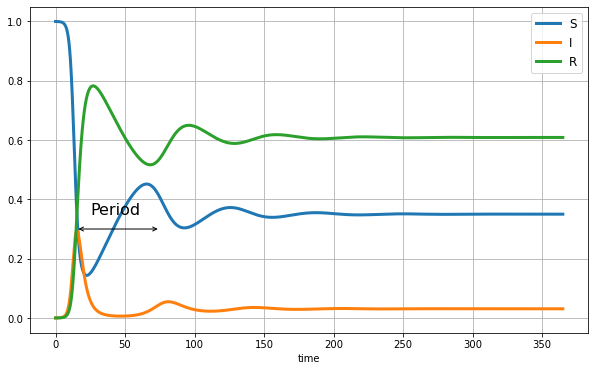

In [209]:
# demographics section

# new differential equations
def fs(s,i):
    return m -b*s*i -m*s

def fi(s,i):
    return b*s*i-g*i -m*i

def fr(s,i):
    return 1-s-i -m*(1-s-i) # the same if fr=g*i-m*r

#set parameters
b=1
g=1/3
m=1/60

def rungekutta_dem(s0,i0,r0):
    
    # SIR data storage
    S=[]
    I=[]
    R=[]
    
    #initial conditions
    S.append(s0)
    I.append(i0)
    R.append(r0)
    
    # set simulation time and time step
    t0=0
    t_final=365
    steps=100_001
    time=np.linspace(t0,t_final,steps)
    N=len(time)
    h=time[1]-time[0]

    # runge-kutta coeff
    for i in range(0,N-1):

        k1=fs(S[i],I[i])
        l1=fi(S[i],I[i])

        k2=fs(S[i]+h/2*k1,I[i]+h/2*l1)
        l2=fi(S[i]+h/2*k1,I[i]+h/2*l1)

        k3=fs(S[i]+h/2*k2,I[i]+h/2*l2)
        l3=fi(S[i]+h/2*k2,I[i]+h/2*l2)

        k4=fs(S[i]+h*k3,I[i]+h*k3)
        l4=fi(S[i]+h*k3,I[i]+h*k3)

        # update values
        S.append(S[i]+h/6*(k1+2*k2+2*k3+k4))
        I.append(I[i]+h/6*(l1+2*l2+2*l3+l4))
        R.append(fr(S[-1],I[-1]))
        
    return S,I,R,time


fig, ax4=plt.subplots(figsize=(10,6))
s,i,r,t=rungekutta_dem(s0=1-1e-4,i0=1e-4,r0=0)
ax4.plot(t,s,t,i,t,r,linewidth=3)
ax4.legend(['S','I','R'],loc='upper right',fontsize='large')
ax4.annotate('', xy=(15,0.3), xytext=(75,0.3), arrowprops=dict(arrowstyle='<->'))
ax4.text(25,0.35,'Period',fontsize=16)
ax4.set_xlabel('time')
ax4.grid()
plt.show()

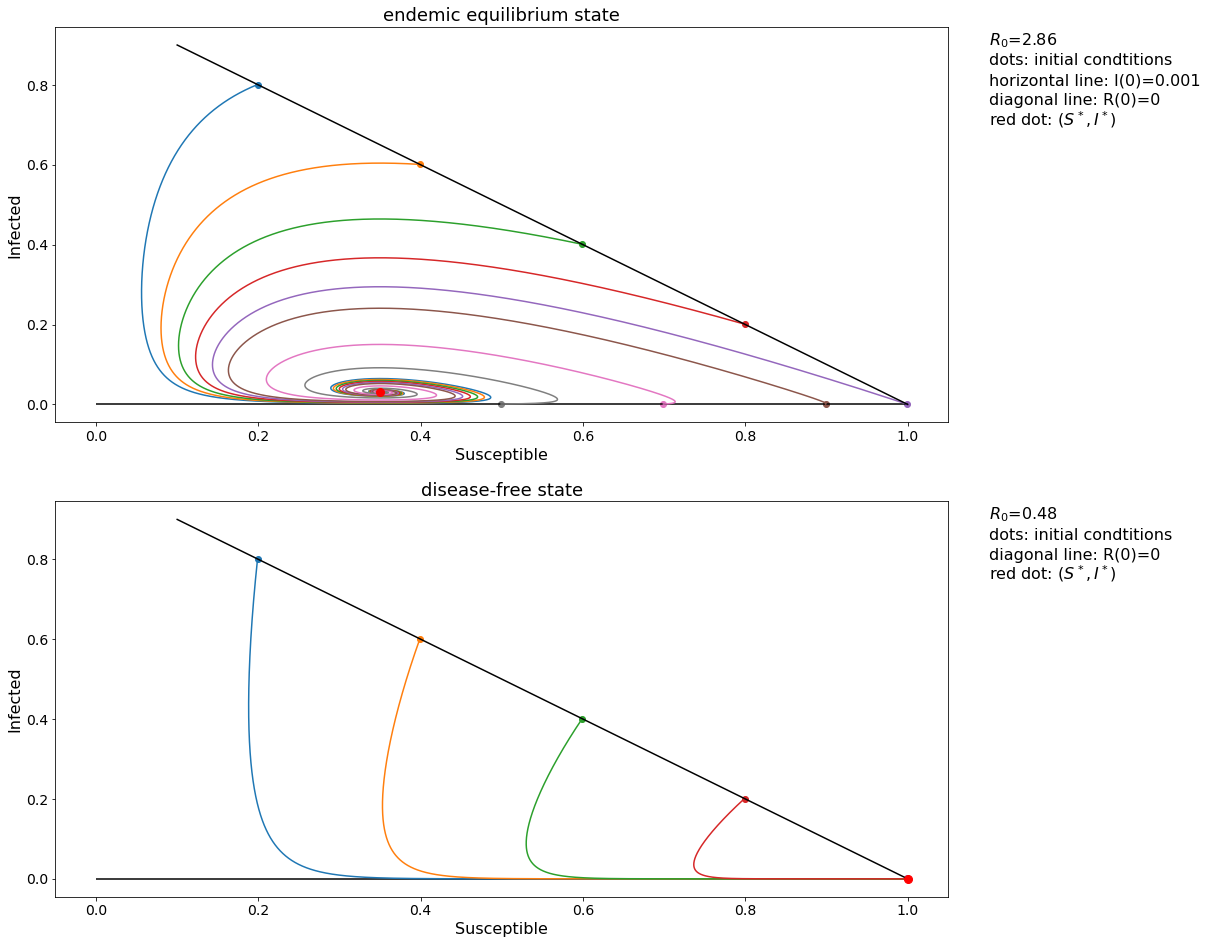

In [211]:
# phase plots

fig, ax5=plt.subplots(2,1,figsize=(16,16))

#set parameters for endemic state
b=1
g=1/3
m=1/60

S0=[x/10 for x in range(2,11,2)]
I0=0.001
for S in S0:
    s,i,_,_=rungekutta_dem(S-I0,1-S+I0,0)
    ax5[0].plot(s,i)
    ax5[0].scatter(S-I0,1-S+I0,marker='o')
    
R0=[R/10 for R in range(1,7,2)]
for R in R0:
    s,i,_,_=rungekutta_dem(1-I0-R,I0,r0=R)
    ax5[0].plot(s,i)
    ax5[0].scatter(1-I0-R,I0,marker='o')

ax5[0].hlines(0,0,1,colors='k')
ax5[0].plot([1,0.1],[0,0.9],'k')
ax5[0].plot([(g+m)/b],[m/b*(b/(g+m)-1)],'ro',ms=8)
ax5[0].set_xlabel('Susceptible',fontsize=16)
ax5[0].set_ylabel('Infected',fontsize=16)
ax5[0].set_title('endemic equilibrium state',fontsize=18)
ax5[0].text(1.1,0.90,f'$R_0$={round(float(b/(g+m)),2)}',fontsize=16)
ax5[0].text(1.1,0.85,f'dots: initial condtitions',fontsize=16)
ax5[0].text(1.1,0.80,f'horizontal line: I(0)=0.001',fontsize=16)
ax5[0].text(1.1,0.75,f'diagonal line: R(0)=0',fontsize=16)
ax5[0].text(1.1,0.70,f'red dot: $(S^*,I^*)$',fontsize=16)
ax5[0].tick_params(axis='x', labelsize=14)
ax5[0].tick_params(axis='y', labelsize=14)

#set parameters for disease free state
b=1/6
g=1/3
m=1/60

for S in S0:
    s,i,_,_=rungekutta_dem(S-I0,1-S+I0,0)
    ax5[1].plot(s,i)
    ax5[1].scatter(S-I0,1-S+I0,marker='o')

ax5[1].hlines(0,0,1,colors='k')
ax5[1].plot([1,0.1],[0,0.9],'k')
ax5[1].plot(1,0,'ro',ms=8)
ax5[1].set_xlabel('Susceptible',fontsize=16)
ax5[1].set_ylabel('Infected',fontsize=16)
ax5[1].set_title('disease-free state',fontsize=18)
ax5[1].text(1.1,0.90,f'$R_0$={round(float(b/(g+m)),2)}',fontsize=16)
ax5[1].text(1.1,0.85,f'dots: initial condtitions',fontsize=16)
ax5[1].text(1.1,0.80,f'diagonal line: R(0)=0',fontsize=16)
ax5[1].text(1.1,0.75,f'red dot: $(S^*,I^*)$',fontsize=16)
ax5[1].tick_params(axis='x', labelsize=14)
ax5[1].tick_params(axis='y', labelsize=14)
plt.show()

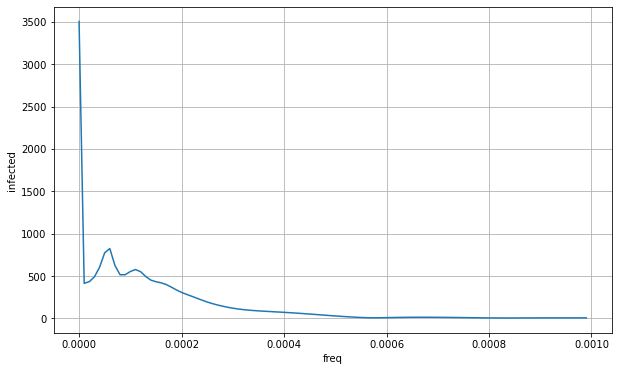

In [764]:
# Fourier analysis

#set parameters for endemic state
b=1
g=1/3
m=1/60

s,i,r,t=rungekutta_dem(s0=1-1e-4,i0=1e-4,r0=0)

yf=fft(i)
L=len(yf)
xf=fftfreq(L)[:L//2]
fig, ax6=plt.subplots(figsize=(10,6))
ax6.plot(xf[:100], np.abs(yf[0:L//2])[:100] )
ax6.grid()
ax6.set_xlabel('freq')
ax6.set_ylabel('infected')
plt.show()

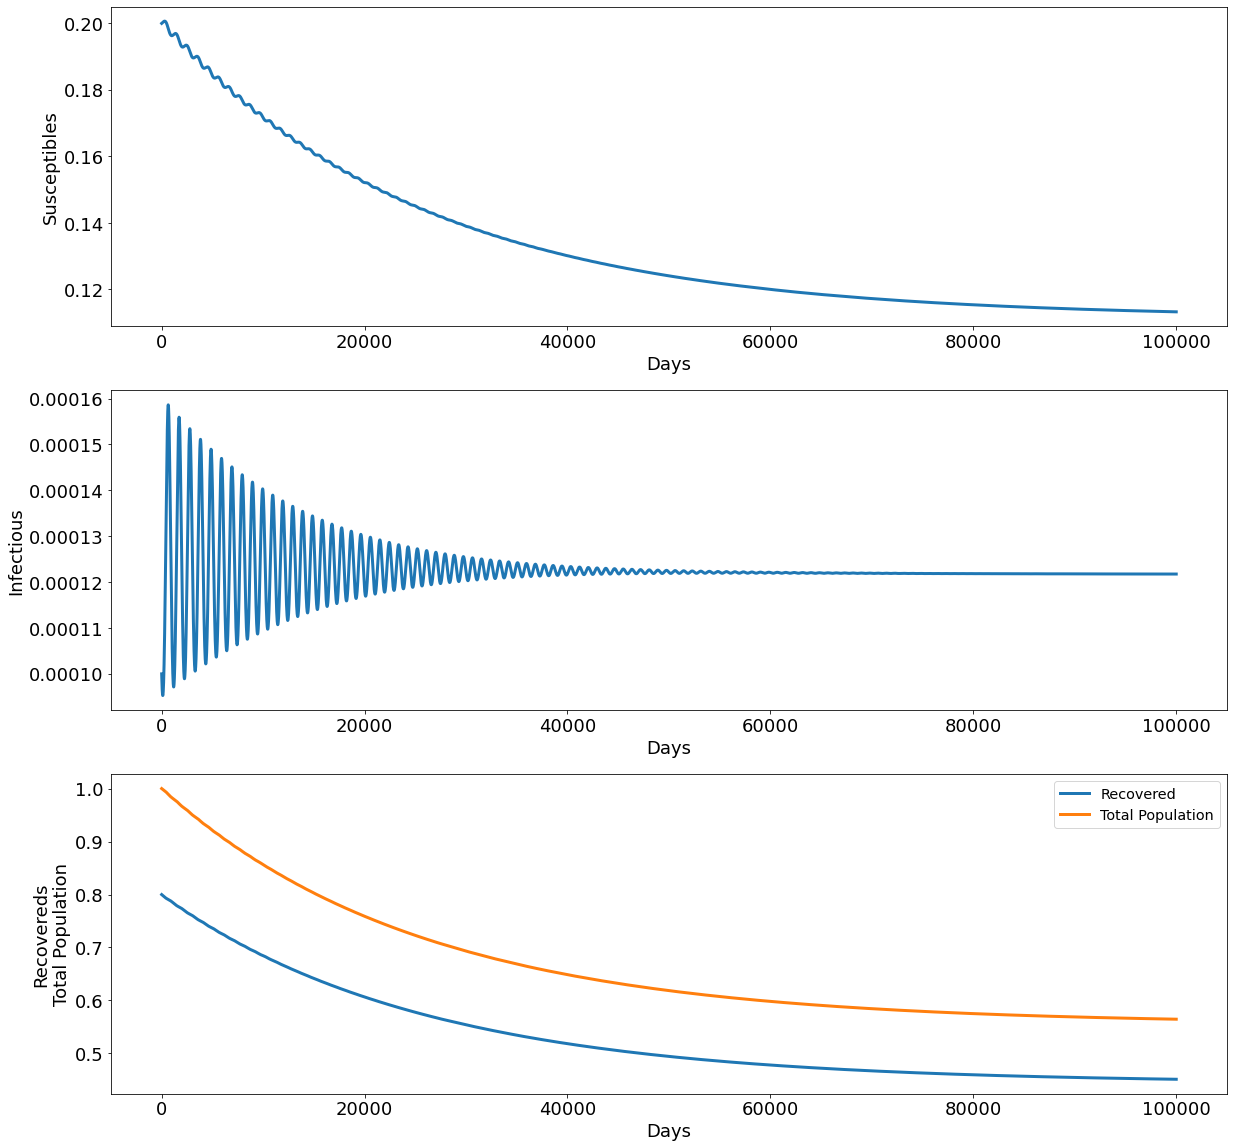

In [199]:
#infection induced mortality - frequency dependant

# new differential equations
def fx(x,y,z):
    return m -b*x*y/(x+y+z) -m*x

def fy(x,y,z):
    return b*x*y/(x+y+z)-(g+m)*y/(1-rho)

def fz(y,z):
    return g*y -m*z

rho=0.5
m=1/(70*365)
b=520/365
g=1/7

def rungekutta_death_freq(n0,x0,y0,z0):
    
    # SIR data storage
    X=[]
    Y=[]
    Z=[]
    NN=[]
    
    #initial conditions
    X.append(x0)
    Y.append(y0)
    Z.append(z0)
    NN.append(n0)
    
    # set simulation time and time step
    t0=0
    t_final=100_000
    steps=20001 #chanced from 100_001 to 20_001 due to stability of the next cell
    time=np.linspace(t0,t_final,steps)
    N=len(time)
    h=time[1]-time[0]

    # runge-kutta coeff
    for i in range(0,N-1):

        k1=fx(X[i],Y[i],Z[i])
        l1=fy(X[i],Y[i],Z[i])
        m1=fz(Y[i],Z[i])

        k2=fx(X[i]+h/2*k1,Y[i]+h/2*l1,Z[i]+h/2*m1)
        l2=fy(X[i]+h/2*k1,Y[i]+h/2*l1,Z[i]+h/2*m1)
        m2=fz(Y[i]+h/2*l1,Z[i]+h/2*m1)

        k3=fx(X[i]+h/2*k2,Y[i]+h/2*l2,Z[i]+h/2*m2)
        l3=fy(X[i]+h/2*k2,Y[i]+h/2*l2,Z[i]+h/2*m2)
        m3=fz(Y[i]+h/2*l2,Z[i]+h/2*m2)

        k4=fx(X[i]+h*k3,Y[i]+h*k3,Z[i]+h*m3)
        l4=fy(X[i]+h*k3,Y[i]+h*k3,Z[i]+h*m3)
        m4=fz(Y[i]+h*k3,Z[i]+h*m3)
        
        # update values
        X.append(X[i]+h/6*(k1+2*k2+2*k3+k4))
        Y.append(Y[i]+h/6*(l1+2*l2+2*l3+l4))
        Z.append(Z[i]+h/6*(m1+2*m2+2*m3+m4))
        NN.append(X[-1]+Y[-1]+Z[-1])
        
    return X,Y,Z,NN,time


x,y,z,n,t = rungekutta_death_freq(n0=1,x0=0.2,y0=1e-4,z0=1-0.2-1e-4)

fig, ax7=plt.subplots(3,1,figsize=(20,20))
ax7[0].plot(t,x,linewidth=3)
ax7[0].set_xlabel('Days',fontsize=18)
ax7[0].set_ylabel('Susceptibles',fontsize=18)
ax7[0].tick_params(axis='x', labelsize=18)
ax7[0].tick_params(axis='y', labelsize=18)
ax7[1].plot(t,y,linewidth=3)
ax7[1].set_xlabel('Days',fontsize=18)
ax7[1].set_ylabel('Infectious',fontsize=18)
ax7[1].tick_params(axis='x', labelsize=18)
ax7[1].tick_params(axis='y', labelsize=18)
ax7[2].plot(t,z,t,n,linewidth=3)
ax7[2].set_xlabel('Days',fontsize=18)
ax7[2].set_ylabel('Recovereds\nTotal Population',fontsize=18)
ax7[2].legend(['Recovered','Total Population'],loc='upper right',fontsize='x-large')
ax7[2].tick_params(axis='x', labelsize=18)
ax7[2].tick_params(axis='y', labelsize=18)

plt.show()


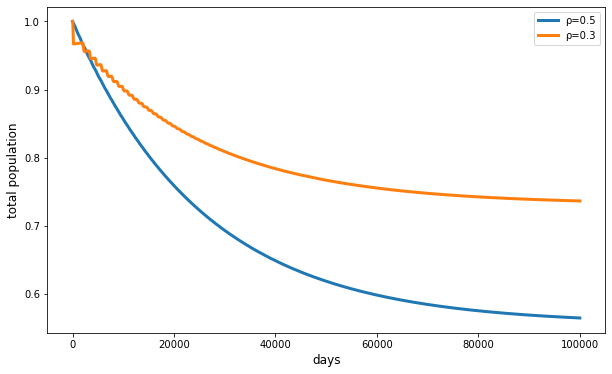

In [200]:
# effect of mortality rho 
m=1/(70*365)
b=520/365
g=1/7
rho=0.5
fig, ax70=plt.subplots(figsize=(10,6))
_,_,_,n,t = rungekutta_death_freq(n0=1,x0=0.2,y0=1e-4,z0=1-0.2-1e-4)
ax70.plot(t,n,linewidth=3,label=f'ρ={rho}')
rho=0.3
_,_,_,n,t = rungekutta_death_freq(n0=1,x0=0.2,y0=1e-4,z0=1-0.2-1e-4)
ax70.plot(t,n,linewidth=3,label=f'ρ={rho}')
ax70.set_xlabel('days',fontsize=12)
ax70.set_ylabel('total population', fontsize=12)
ax70.legend()
plt.show()

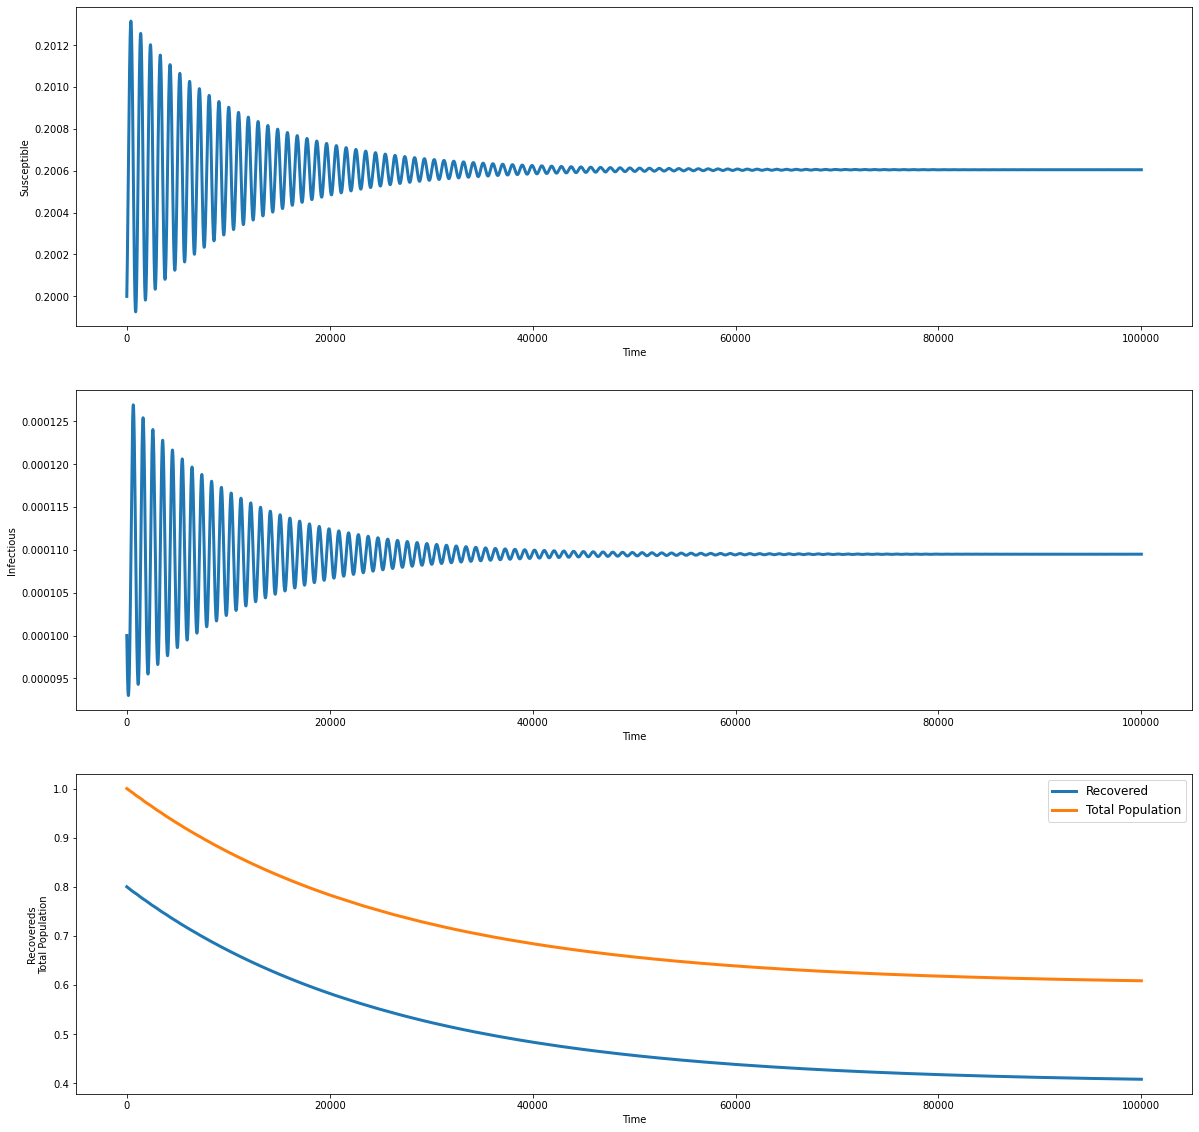

In [766]:
#infection induced mortality - density dependant - not in report

# new differential equations
def fx(x,y):
    return m -b*x*y -m*x

def fy(x,y):
    return b*x*y-(g+m)*y/(1-rho)

def fz(y,z):
    return g*y -m*z

rho=0.5
m=1/(70*365)
b=520/365
g=1/7

def rungekutta_death_dens(n0,x0,y0,z0):
    
    # SIR data storage
    X=[]
    Y=[]
    Z=[]
    NN=[] # for not to mix the variables
    
    #initial conditions
    X.append(x0)
    Y.append(y0)
    Z.append(z0)
    NN.append(n0) 
    
    # set simulation time and time step
    t0=0
    t_final=100_000
    steps=100_001
    time=np.linspace(t0,t_final,steps)
    N=len(time)
    h=time[1]-time[0]

    # runge-kutta coeff
    for i in range(0,N-1):

        k1=fx(X[i],Y[i])
        l1=fy(X[i],Y[i])
        m1=fz(Y[i],Z[i])

        k2=fx(X[i]+h/2*k1,Y[i]+h/2*l1)
        l2=fy(X[i]+h/2*k1,Y[i]+h/2*l1)
        m2=fz(Y[i]+h/2*l1,Z[i]+h/2*m1)

        k3=fx(X[i]+h/2*k2,Y[i]+h/2*l2)
        l3=fy(X[i]+h/2*k2,Y[i]+h/2*l2)
        m3=fz(Y[i]+h/2*l2,Z[i]+h/2*m2)

        k4=fx(X[i]+h*k3,Y[i]+h*k3)
        l4=fy(X[i]+h*k3,Y[i]+h*k3)
        m4=fz(Y[i]+h*k3,Z[i]+h*m3)
        
        # update values
        X.append(X[i]+h/6*(k1+2*k2+2*k3+k4))
        Y.append(Y[i]+h/6*(l1+2*l2+2*l3+l4))
        Z.append(Z[i]+h/6*(m1+2*m2+2*m3+m4))
        NN.append(X[-1]+Y[-1]+Z[-1])
        
    return X,Y,Z,NN,time


x,y,z,n,t = rungekutta_death_dens(n0=1,x0=0.2,y0=1e-4,z0=1-0.2-1e-4)


fig, ax8=plt.subplots(3,1,figsize=(20,20))
ax8[0].plot(t,x,linewidth=3)
ax8[0].set_xlabel('Time')
ax8[0].set_ylabel('Susceptible')
ax8[1].plot(t,y,linewidth=3)
ax8[1].set_xlabel('Time')
ax8[1].set_ylabel('Infectious')
ax8[2].plot(t,z,t,n,linewidth=3)
ax8[2].set_xlabel('Time')
ax8[2].set_ylabel('Recovereds\nTotal Population')
ax8[2].legend(['Recovered','Total Population'],loc='upper right',fontsize='large')

pl.show()


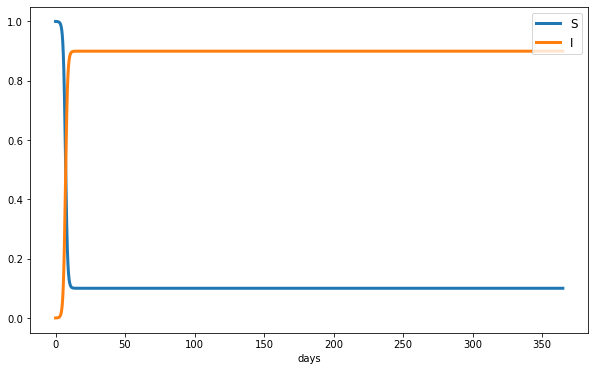

In [201]:
# SIS model

# new differential equations
def fs(s,i):
    return -b*s*i +g*i

def fi(s,i):
    return b*s*i-g*i

#set parameters
b=520/365
g=1/7

def rungekutta_SIS(s0=1-1e-4,i0=1e-4):
    
    # SIR data storage
    S=[]
    I=[]
    
    #initial conditions // given or default case
    S.append(s0)
    I.append(i0)
    
    # set simulation time and time step
    t0=0
    t_final=365
    steps=100_001
    time=np.linspace(t0,t_final,steps)
    N=len(time)
    h=time[1]-time[0]

    # runge-kutta coeff
    for i in range(0,N-1):

        k1=fs(S[i],I[i])
        l1=fi(S[i],I[i])

        k2=fs(S[i]+h/2*k1,I[i]+h/2*l1)
        l2=fi(S[i]+h/2*k1,I[i]+h/2*l1)

        k3=fs(S[i]+h/2*k2,I[i]+h/2*l2)
        l3=fi(S[i]+h/2*k2,I[i]+h/2*l2)

        k4=fs(S[i]+h*k3,I[i]+h*k3)
        l4=fi(S[i]+h*k3,I[i]+h*k3)

        # update values
        S.append(S[i]+h/6*(k1+2*k2+2*k3+k4))
        I.append(I[i]+h/6*(l1+2*l2+2*l3+l4))
        
    return S,I,time


fig, ax9=plt.subplots(figsize=(10,6))
s,i,t=rungekutta_SIS()
ax9.plot(t,s,t,i,linewidth=3)
ax9.legend(['S','I'],loc='upper right',fontsize='large')
ax9.set_xlabel('days')
plt.show()




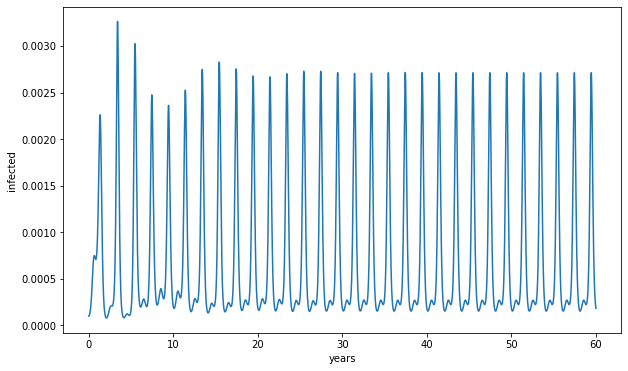

In [215]:
#seasonality
# new differential equations
def fs(t,s,i):
    b=b0*(1+b1*np.sin(2*np.pi*t/365))
    return m- b*s*i -m*i

def fi(t,s,i):
    b=b0*(1+b1*np.sin(2*np.pi*t/365))
    return b*s*i- m*i- g*i

#set parameters
b0=1.308;
b1=0.1;
g=0.077;
m=1/(50*365);

def rungekutta_season(s0,i0,r0):
    
    # SIR data storage
    S=[]
    I=[]
    R=[]
    
    #initial conditions // given or default case
    S.append(s0)
    I.append(i0)
    R.append(r0)
    
    # set simulation time and time step
    t0=0
    t_final=365*60
    steps=t_final+1
    time=np.linspace(t0,t_final,steps)
    N=len(time)
    h=time[1]-time[0]

    # runge-kutta coeff
    for i in range(0,N-1):

        k1=fs(time[i],S[i],I[i])
        l1=fi(time[i],S[i],I[i])

        k2=fs(time[i]+h/2,S[i]+h/2*k1,I[i]+h/2*l1)
        l2=fi(time[i]+h/2,S[i]+h/2*k1,I[i]+h/2*l1)

        k3=fs(time[i]+h/2,S[i]+h/2*k2,I[i]+h/2*l2)
        l3=fi(time[i]+h/2,S[i]+h/2*k2,I[i]+h/2*l2)

        k4=fs(time[i]+h,S[i]+h*k3,I[i]+h*k3)
        l4=fi(time[i]+h,S[i]+h*k3,I[i]+h*k3)

        # update values
        S.append(S[i]+h/6*(k1+2*k2+2*k3+k4))
        I.append(I[i]+h/6*(l1+2*l2+2*l3+l4))
        R.append(1-S[-1]-I[-1])
    return S,I,R,time

s,i,r,t=rungekutta_season(s0=0.0588,i0=1e-4,r0=1-0.0588-1e-4)
fig, ax10=plt.subplots(figsize=(10,6))
ax10.plot(t/365,i)
ax10.set_xlabel('years')
ax10.set_ylabel('infected')
plt.show()

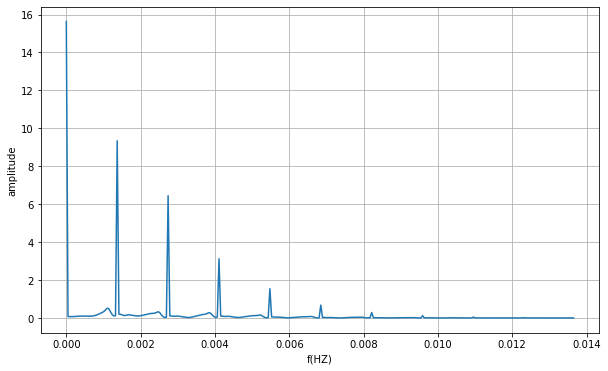

In [214]:
# Fourier analysis

#set parameters
b0=1.308;
b1=0.1;
g=0.077
m=1/(50*365);

_,i,_,_=rungekutta_season(s0=1/17,i0=1e-4,r0=1-1/17-1e-4)

yf=fft(i)
L=len(yf)
xf=fftfreq(L)[:L//2]
fig, ax600=plt.subplots(figsize=(10,6))
ax600.plot(xf[:300], np.abs(yf[0:L//2])[:300] )
ax600.grid()
ax600.set_xlabel('f(HZ)')
ax600.set_ylabel('amplitude')
plt.show()

In [770]:
# bifurcation diagram - TOO SLOW - commect it out
# #set parameters
# b0=1.308;
# g=0.077;
# m=1/(50*365);

# def rungekutta_bif(s0,b1):
#     def fs(t,s,i):
#         b=b0*(1+b1*np.sin(2*np.pi*t/365))
#         return m- b*s*i -m*i

#     def fi(t,s,i):
#         b=b0*(1+b1*np.sin(2*np.pi*t/365))
#         return b*s*i- m*i- g*i
   
#     # SIR data storage
#     S=[]
#     I=[]
#     R=[]
    
#     #initial conditions // given or default case
#     S.append(s0)
#     I.append(1e-4)
#     R.append(1-s0-1e-4)
    
#     # set simulation time and time step
#     t0=0
#     t_final=365*60
#     steps=t_final+1
#     time=np.linspace(t0,t_final,steps)
#     N=len(time)
#     h=time[1]-time[0]

#     # runge-kutta coeff
#     for i in range(0,N-1):

#         k1=fs(time[i],S[i],I[i])
#         l1=fi(time[i],S[i],I[i])

#         k2=fs(time[i]+h/2,S[i]+h/2*k1,I[i]+h/2*l1)
#         l2=fi(time[i]+h/2,S[i]+h/2*k1,I[i]+h/2*l1)

#         k3=fs(time[i]+h/2,S[i]+h/2*k2,I[i]+h/2*l2)
#         l3=fi(time[i]+h/2,S[i]+h/2*k2,I[i]+h/2*l2)

#         k4=fs(time[i]+h,S[i]+h*k3,I[i]+h*k3)
#         l4=fi(time[i]+h,S[i]+h*k3,I[i]+h*k3)

#         # update values
#         S.append(S[i]+h/6*(k1+2*k2+2*k3+k4))
#         I.append(I[i]+h/6*(l1+2*l2+2*l3+l4))
#         R.append(1-S[-1]-I[-1])

#     return I[365*56],I[365*57],I[365*58],I[365*59]

# iteret = 100
# b1=np.linspace(0,0.25,iteret)
# fig, ax100=plt.subplots(figsize=(10,6))
# bif=np.zeros((iteret,4))
# for it in range(iteret):
#     bif[it,:]=rungekutta_bif(0.5,b1[it])

# for it in range(4):
#     ax100.plot(b1, bif[:,it],'ob',ms=2)
# ax100.set_xlabel(f'Amplitude of Seasonality $β_1$')
# ax100.set_ylabel('Infectives')
# plt.show()